# Compare OpenMC deplete with FNS experiment results and Fispact simulations.

First import all the Python packages that we will need

In [ ]:
import copy
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import openmc
import openmc.deplete
import pypact as pp  # can be installed with pip install pypact

from openmc_activator import OpenmcActivator

Read all the experiments from unzipped fns folder.

In [2]:

here = Path('./fns')
assert(here.exists()), 'fns folder does not seem to exist. Run `download_fns_fusion_decay.py` first to download and unzip FNS benchmark files.'
experiments = {}
files = [q for q in here.glob('*') if q.is_dir()]
for f in files:
    if '_' in f.name: continue
    l = list(f.glob('*fluxes*'))
    experiments[f.name] = []
    for name in l:
        x = name.name.replace('_fluxes', '')
        experiments[f.name].append(x)

Reads the Fispact fluxes file that contains the neutron spectra

In [15]:
def read_flux(flux_file):
    ff = pp.FluxesFile()
    pp.from_file(ff, flux_file)
    energy_bound_ascending, bin_values = ff.boundaries, ff.values
    return energy_bound_ascending, bin_values

# read flux data
flux_dict = {}
for k,l in experiments.items():
    flux_dict[k] = {}
    for exp in l:
        flux_path = here / k / (exp+'_fluxes')
        flux_path = str(flux_path.absolute())
        ebins, fluxes = read_flux(flux_path)
        assert(len(fluxes) == 709)
        flux_dict[k][exp] = fluxes

Plot and example irradiation neutron spectra.

This example plots the neutron spectra used to irradiate silver (Ag) in the 2000 experimental campaign for 5 minutes of irradiation.

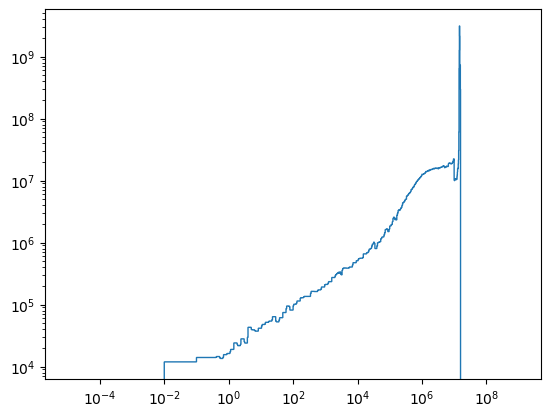

In [13]:
# in this case we plot the silver Ag experiment spectrum but you could plot others
plt.stairs(values=flux_dict['Ag']['2000exp_5min'], edges=ebins)
plt.yscale('log')
plt.xscale('log')


Next we read in the experimental data so that it is in a more accessible form.
The times, data and uncertainties are read in.

In [8]:
def read_experimental_data(exp_file):
    lines = open(exp_file).readlines()
    minutes = [q.strip().split()[0] for q in lines]
    # it's not always days actually, check other file
    vals = [q.strip().split()[1] for q in lines]
    unc = [q.strip().split()[2] for q in lines]
    return np.array(minutes, dtype=float), np.array(vals, dtype=float), np.array(unc, dtype=float)

# TODO consider replacing with pypact
def is_days(input_file):
    lines = open(input_file, 'r').readlines()
    lines = [q for q in lines if 'TIME' in lines]
    day_cnt = 0
    for line in lines:
        if 'DAYS' in line: day_cnt += 1
    if day_cnt == len(lines):
        return True
    elif day_cnt == 0:
        return False
    else:
        raise ValueError('Something is not right')

exp_data_dict = {'minutes': {}, 'data': {}, 'unc': {}}
for k,l in experiments.items():
    for k_ in exp_data_dict:
        exp_data_dict[k_][k] = {}
    for exp in l:
        exp_path = here / k / (exp+'.exp')
        exp_path = str(exp_path.absolute())
        input_path = here / k / ('TENDL-2017_' + exp + '.i')
        input_path = str(input_path.absolute())
        is_day = is_days(input_path)
        mins, vals, uncs = read_experimental_data(exp_path)
        if is_day:
            exp_data_dict['minutes'][k][exp] = mins * 60 * 24
        else:
            exp_data_dict['minutes'][k][exp] = mins
        exp_data_dict['data'][k][exp] = vals
        exp_data_dict['unc'][k][exp] = uncs
        assert(len(mins) == len(vals))

Now we get the irradiation setup including the flux and timesteps

In [ ]:
# TODO consider replacing with pypact
def read_irr_setup(filepath):
    lines = open(filepath).readlines()
    days_list = []
    flux_mag_list = []
    for line in lines:
        spl = line.strip().split()
        if 'FLUX' in line:
            assert(len(spl) == 2)
            flux_mag = float(spl[1])
        if 'TIME' in line:
            time_indx = spl.index('TIME')
            time_num = float(spl[time_indx+1])
            unit = spl[time_indx+2]
            if unit == 'ATOMS':
                time_num = time_num / (3600*24)
            elif unit == 'MINS':
                time_num = time_num / (60*24)
            elif unit == 'HOURS':
                time_num = time_num / (24)
            elif unit == 'DAYS':
                time_num = time_num
            elif unit == 'YEARS':
                time_num = time_num * 365.25
            else:
                raise ValueError('Unrecognized unit [%s]' %unit)
            
            days_list.append(time_num)
            flux_mag_list.append(flux_mag)
    return days_list, flux_mag_list

# TODO consider replacing with pypact
def read_mat_setup(filepath):
    lines = open(filepath).readlines()
    for indx, line in enumerate(lines):
        spl = line.strip().split()
        if 'MASS' in line:
            assert(len(spl) == 3)
            assert(spl[0] == 'MASS')
            mass = float(spl[1]) # kg
            num_entry = int(spl[2])
            break
    comp_dict = {}
    for i in range(num_entry):
        line = lines[indx+i+1]
        spl = line.strip().split()
        assert(len(spl) == 2)
        comp_dict[spl[0]] = float(spl[1])
    tot = sum(comp_dict.values())
    mass_dict = {k:v/tot * mass for k,v in comp_dict.items()}
    return mass_dict

# TODO consider replacing with pypact
def read_density(filepath):
    lines = open(filepath).readlines()
    for line in lines:
        spl = line.strip().split()
        if 'DENSITY' in line:
            assert('DENSITY' == spl[0])
            return float(spl[1])
    raise ValueError('Density not found')


setup_dict = {'days': {}, 'flux_mag': {}, 'mass': {}, 'density': {}}
for k,l in experiments.items():
    for k_ in setup_dict:
        setup_dict[k_][k] = {}
    for exp in l:
        input_path = here / k / ('TENDL-2017_' + exp + '.i')
        input_path = str(input_path.absolute())
        days, flux_mag = read_irr_setup(input_path)
        days = np.cumsum(days)
        # kg to grams
        mass_dict = {k:v*1e3 for k,v in read_mat_setup(input_path).items()}
        setup_dict['days'][k][exp] = days
        setup_dict['flux_mag'][k][exp] = flux_mag
        setup_dict['mass'][k][exp] = mass_dict
        setup_dict['density'][k][exp] = read_density(input_path)
        assert(len(days) == len(flux_mag))
        assert(isinstance(mass_dict, dict))

setup_dict['mg_flux'] = flux_dict
setup_dict['ebins'] = ebins

Now we can carry out depletion simulations in OpenMC

Set the chain file and cross sections to let OpenMC know where to find the data.

The nuclear data used can have an impact on how closely the results match.

To make this a fair comparison we recommend using the same nuclear data as the original Fispact simulations (Tendl 2017) and the chain file provided within the repository.

In [ ]:
# TODO find a more general path
# TODO Consider adding chain file + cross sections to repo
openmc.config['cross_sections'] = '/home/4ib/git/openmc_data/endfb-viii.0-hdf5/cross_sections.xml'
openmc.config['chain_file'] = '/home/4ib/git/openmc_data/depletion/chain_xs_tendl2019_dec_endf80_nfy_endf80.xml'

openmc.config['chain_file'] = '/home/jon/nuclear_data/chain-endf-b8.0.xml'
openmc.config['cross_sections'] = '/home/jon/nuclear_data/cross_sections.xml'

/home/jon/openmc/openmc/config.py:65: UserWarning: '/home/4ib/git/openmc_data/endfb-viii.0-hdf5/cross_sections.xml' does not exist.
  warnings.warn(f"'{value}' does not exist.")
/home/jon/openmc/openmc/config.py:65: UserWarning: '/home/4ib/git/openmc_data/depletion/chain_xs_tendl2019_dec_endf80_nfy_endf80.xml' does not exist.
  warnings.warn(f"'{value}' does not exist.")


Next we use the experiment descriptions to make OpenMC simulations

The irradiation duration, spectra, flux, material and mass are found from the IAEA Conderc benchmarks and passed to OpenMC functions to perform simulations of the experimental setup.

In [ ]:
openmc_result_dict = {}
for k, l in experiments.items():
    
    # this loop currently just simulates the Ag irradiation but can be easily
    # changed to do every nuclide in the benchmark suit by commenting the
    # line below.
    if k != 'Ag': continue
    
    print(f'Running OpenMC for {k} {l}')
    
    if k not in openmc_result_dict:
        openmc_result_dict[k] = {}
    for exp in l:
        if exp in openmc_result_dict[k]:
            continue
        ccfe_flux = flux_dict[k][exp]
        # ebins is ccfs 709 flux bins
        # low to high
        # create new chain file
        obj = OpenmcActivator(ebins[::-1], ccfe_flux[::-1])

        # mass in grams
        mass_dict = setup_dict['mass'][k][exp]
        days_list = setup_dict['days'][k][exp]
        # days are cumulative, so we gotta provide diffs
        days_list = np.append(days_list[0], np.diff(days_list))
        flux_mag_list = setup_dict['flux_mag'][k][exp]

        # make openmc material
        mat = openmc.Material()
        for el, md in mass_dict.items():
            el = el.lower().capitalize()
            mat.add_element(el, md, percent_type='wo')
        mat.set_density('g/cm3', setup_dict['density'][k][exp])
        mat.depletable = True
        tot_mass = sum(mass_dict.values())
        mat.volume = tot_mass / mat.density

        # activate
        metric_dict = obj.activate(mat,
                                flux_mag_list,
                                days_list,
                                # split_irr=n_split,
                                metric_list=['mass', 'decay_heat'])
        openmc_result_dict[k][exp] = copy.deepcopy(metric_dict)


Next we process the Fispact simulations results from the IAEA Conderc benchmarks so that they are ready to plot next to the OpenMC simulation results and the experimental benchmark results.

In [1]:

def read_fispact_output(filepath):
    lines = open(filepath).readlines()
    # don't read empty lines
    read = False

    lines = [q for q in lines if q.strip()]
    step = 0
    # get header
    # usually the last # line
    for indx, line in enumerate(lines):
        if read:
            spl = line.strip().split()
            now_step = int(spl[0])
            assert(step +1 == now_step)
            step = now_step
            assert(len(spl) == len(col_names)), print(len(spl), len(col_names), '\n', col_names)
            for indx, val in enumerate(spl):
                key = col_names[indx]
                if key == 'step':
                    d[key].append(int(val))
                else:
                    d[key].append(float(val))
            continue
        if line[0] == '#' and lines[indx+1][0] != '#':
            # this line with the column names
            # terrible
            l = line.strip().split()[1:]
            indx = 0
            new_l = []
            while True:
                if indx >= len(l):
                    break
                if l[indx].isalpha():
                    if l[indx+1][-1] == 'm': # metastable
                        if l[indx+1][:-1].isnumeric():
                            new_l.append(l[indx]+l[indx+1])
                            indx += 2
                        else:
                            new_l.append(l[indx])
                            indx += 1
                    else:
                        if l[indx+1].isnumeric(): # metastable
                            new_l.append(l[indx]+l[indx+1])
                            indx += 2
                        else:
                            new_l.append(l[indx])
                            indx += 1
                else:
                    new_l.append(l[indx])
                    indx += 1
            d = {k:[] for k in new_l}
            read = True
            col_names = copy.deepcopy(new_l)
            continue
    return d


fispact_result_dict = {}
for k,l in experiments.items():
    fispact_result_dict[k] = {}
    for exp in l:
        output_path = here / k / f'TENDL-2017_{exp}.nuclides'
        fispact_result_dict[k][exp] = read_fispact_output(output_path.resolve())

NameError: name 'experiments' is not defined

We combine the Fispact results (which are per nuclide) so that we have the total values for decay heat.

In [ ]:
fispact_imp_nuclides = {}
for k,l in experiments.items():
    fispact_imp_nuclides[k] = {}
    for exp in l:
        tot = fispact_result_dict[k][exp]['Total']
        indices = [1, len(tot)//2, -1]
        fispact_imp_nuclides[k][exp] = {}
        for i in indices:
            td = {k:v[i] for k,v in fispact_result_dict[k][exp].items() if k not in ['step', 'time', 'uncert', 'Total']}
            td = {k:v for k,v in sorted(td.items(), key=lambda item:item[1], reverse=True)}
            fispact_imp_nuclides[k][exp][i] = td


Inc600
F
Pb
Lu
Te
La
Ag
Cl
Ho
Yb
I
Bi
Mn
Sm
Fe
S
Re
Ge
Ga
Hf
Os
Er
Si
Nb
Pt
Cd
Ti
In
Ru
Eu
Sr
Sb
Sn
Mg
Rb
Mo
SS316
Cs
Y
Ca
Co
Na
Br
V
Tm
K
Gd
Sc
Ta
Zr
Tb
Al
Ba
Ce
Au
Pd
Tl
W
P
Ni
Nd
SS304
NiCr
Cr
Zn
Rh
Pr
Hg
Se
Ir
As
Dy
Cu


We now have the OpenMC outputs, Fispact and experimental results in a convenient form  ready for plotting.

The next code block plots the results so that they can be compared.

Ag
1 {'Ag108': 1.09653e-06, 'Ag106': 5.65171e-07, 'Ag110': 1.87006e-07, 'Ag107m': 5.66618e-08, 'Ag109m': 4.56189e-08, 'Rh104': 3.4799e-08, 'Rh106': 5.32129e-09, 'Pd109m': 3.1127e-09, 'Rh104m': 2.80227e-09, 'Ag106m': 2.09887e-09, 'Pd107m': 1.55064e-09, 'Rh106m': 9.91648e-10, 'Pd109': 8.62904e-11}
10 {'Ag106': 4.8286e-07, 'Ag108': 2.27213e-07, 'Rh104': 1.06202e-08, 'Ag106m': 2.09822e-09, 'Pd109m': 1.391e-09, 'Rh104m': 1.17351e-09, 'Rh106m': 9.63671e-10, 'Ag107m': 3.39797e-10, 'Ag109m': 1.76068e-10, 'Pd109': 1.04779e-10, 'Ag110': 1.83549e-11, 'Pd107m': 0.0, 'Rh106': 0.0}
-1 {'Ag106': 1.19558e-07, 'Ag106m': 2.09246e-09, 'Rh106m': 7.47658e-10, 'Pd109': 1.15353e-10, 'Ag109m': 2.8106e-11, 'Rh104': 4.68759e-12, 'Pd109m': 1.09772e-12, 'Rh104m': 5.20174e-13, 'Pd107m': 0.0, 'Rh106': 0.0, 'Ag107m': 0.0, 'Ag110': 0.0, 'Ag108': 0.0}


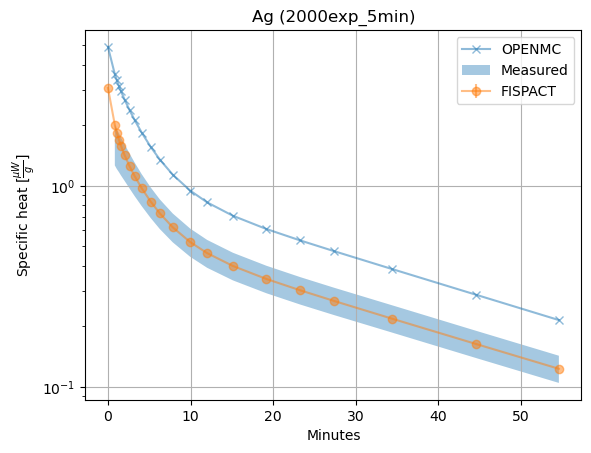

In [ ]:
for k,l in openmc_result_dict.items():
    for exp in l:
        fispact = fispact_result_dict[k][exp] # results in watts per gram
        t_fispact = np.array(fispact['time']) * 365.25 * 60 * 24 # minutes
        fispact_microwatt_gram = np.array(fispact['Total']) * 1e6
        fispact_uncert = np.array(fispact['uncert'])  * 1e6


        # openmc 
        t_openmc = openmc_result_dict[k][exp]['mass']['meta_time_d']
        # t_openmc = np.diff(t_openmc)
        decay_indx = 1
        t0 = t_openmc[decay_indx]
        t_openmc = t_openmc[decay_indx:] - t0
        openmc = openmc_result_dict[k][exp]['decay_heat']['meta_total']
        mass = openmc_result_dict[k][exp]['mass']['meta_total']
        openmc = np.array(openmc) / np.array(mass)
        openmc = openmc[decay_indx:] * 1e6 # watts to microwatts
        # days to minutes
        t_openmc = t_openmc * (60*24)
        # add on 0
        plt.plot(t_openmc, openmc, label='OPENMC', marker='x', alpha=0.5)



        measured = exp_data_dict['data'][k][exp]
        t_measured = exp_data_dict['minutes'][k][exp]
        unc_measured = exp_data_dict['unc'][k][exp]
        # add irradiation time to t_measured
        t_measured = np.array(t_measured)

        for index,sorted_dict in fispact_imp_nuclides[k][exp].items():
            print(index, sorted_dict)

        if 'hour' not in exp:
            t_measured = t_measured / (60*24)
        # plt.errorbar(t_measured, measured, unc_measured, label='Measured', linestyle='--', marker='x')
        plt.fill_between(t_measured, measured-(3*unc_measured), measured+(3*unc_measured),
                         alpha=0.4, label='Measured')
        plt.errorbar(t_fispact, fispact_microwatt_gram, fispact_uncert, label='FISPACT', marker='o', alpha=0.5)
        # plt.plot(t_origen, origen, label='ORIGEN', marker='1', alpha=0.5)
        plt.yscale('log')
        plt.xlabel('Minutes')
        plt.ylabel(r'Specific heat [$\frac{\mu W}{g}$]')
        plt.legend()
        plt.grid()
        plt.title(k + ' (%s)' %(exp))
        plt.show()
        plt.close()
